# Подключаем библиотеки

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, classification_report
from sklearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, roc_curve, auc, classification_report)

<h3> Очистка данных

Записываем наши файлы в переменные, затем выводим виды колонок по каждому файлу.
train - для обучения модели
valid - для тестирования модели

In [4]:
data_train = pd.read_csv('train.csv', low_memory=False)
data_valid = pd.read_csv('valid.csv', low_memory=False)

numeric_columns = data_train.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = data_train.select_dtypes(include=['object']).columns
boolean_columns = data_train.select_dtypes(include=['bool']).columns

print(f"Числовые колонки в train.csv: {len(numeric_columns)}")
print(f"Категориальные колонки в train.csv: {len(categorical_columns)}")
print(f"Булевые колонки в train.csv: {len(boolean_columns)}")

numeric_columns = data_valid.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = data_valid.select_dtypes(include=['object']).columns
boolean_columns = data_valid.select_dtypes(include=['bool']).columns

print("")
print(f"Числовые колонки в valid.csv: {len(numeric_columns)}")
print(f"Категориальные колонки в valid.csv: {len(categorical_columns)}")
print(f"Булевые колонки в valid.csv: {len(boolean_columns)}")

Числовые колонки в train.csv: 2319
Категориальные колонки в train.csv: 347
Булевые колонки в train.csv: 0

Числовые колонки в valid.csv: 2332
Категориальные колонки в valid.csv: 334
Булевые колонки в valid.csv: 0


Предобрабатываем данные:  
- Меняем тип данных у колонки `report_date` на `datetime` для создания временных признаков.  
- Добавляем 3 колонки:  
  - `days_since_last_report` — разница в днях между текущей и предыдущей датой для каждого клиента.  
  - `days_until_next_report` — количество дней до следующего отчета.  
  - `record_index` — накопительный счетчик записей для каждого клиента.  
- Удаляем низкокачественные столбцы, где менее 75% данных заполнено.  
- Заполняем пропуски на уровне клиента методами `ffill` и `bfill`, чтобы сохранить временную структуру.  
- Удаляем дубликаты записей.  
- Заполняем числовые пропуски медианой в числовых колонках.  
- Приводим структуру валидационных данных в соответствие с тренировочными.  
- Сравниваем количество колонок и строк до и после обработки.

In [5]:
# Преобразование дат в формат datetime
def preprocess_dates(data):
    if 'report_date' in data.columns:
        data['report_date'] = pd.to_datetime(data['report_date'], errors='coerce')
    return data

# Создание временных признаков
def create_time_features(data):
    # Упорядочиваем данные по client_id и report_date
    data = data.sort_values(['client_id', 'report_date'])
    
    # Разница в днях между текущей и предыдущей датой для каждого клиента
    data['days_since_last_report'] = data.groupby('client_id')['report_date'].diff().dt.days.fillna(0)
    
    # Количество дней до следующего отчета (где возможно)
    data['days_until_next_report'] = data.groupby('client_id')['report_date'].diff(-1).dt.days.fillna(0)
    
    # Накопительный счетчик записей для каждого клиента
    data['record_index'] = data.groupby('client_id').cumcount() + 1
    
    return data

# Обработка пропусков без потери временной структуры
def fill_missing_values(data):
    # Заполняем пропуски только в пределах клиента
    data = data.groupby('client_id').apply(lambda group: group.fillna(method='ffill').fillna(method='bfill'))
    return data

# Удаление колонок с низким качеством данных
def drop_low_quality_columns(data, threshold=0.75):
    # Удаление колонок, где все значения NaN
    data = data.dropna(axis=1, how='all')
    
    # Удаление колонок, где менее 75% данных заполнено
    data = data.loc[:, (data.notna()).mean() > threshold]
    return data

# Основной пайплайн обработки данных
def process_data(data, skip_drop_col):
    # Преобразуем даты
    data = preprocess_dates(data)
    
    # Добавляем временные признаки
    data = create_time_features(data)

    if skip_drop_col:
        # Удаляем низкокачественные столбцы
        data = drop_low_quality_columns(data)
        # # Удаляем строки, где менее 75% данных заполнено
        # data = data[data.notna().mean(axis=1) > 0.75]

    # Заполняем пропуски на уровне клиента
    data = fill_missing_values(data)
    
    # Удаляем дубликаты
    data = data.drop_duplicates()
    
    return data

# Применение обработки к train и valid
data_cleaned_train = process_data(data_train, True)
data_cleaned_valid = process_data(data_valid, False)

# Приведение колонок valid к train (если в train остались неиспользуемые колонки)
data_cleaned_valid = data_cleaned_valid[data_cleaned_train.columns]
# data_cleaned_valid = data_cleaned_valid[data_cleaned_valid.notna().mean(axis=1) > 0.75]

# Работа с числовыми столбцами: заполнение медианой
numeric_columns_train = data_cleaned_train.select_dtypes(include=['int64', 'float64']).columns
numeric_columns_valid = data_cleaned_valid.select_dtypes(include=['int64', 'float64']).columns

imputer = SimpleImputer(strategy='median')
data_cleaned_train[numeric_columns_train] = imputer.fit_transform(data_cleaned_train[numeric_columns_train])
data_cleaned_valid[numeric_columns_valid] = imputer.transform(data_cleaned_valid[numeric_columns_valid])

# Сравнение до и после обработки
print(f"До удаления колонок (train.csv): {data_train.shape[1]} колонок")
print(f"После удаления колонок (train.csv): {data_cleaned_train.shape[1]} колонок")
print(f"Число строк до удаления (train.csv): {data_train.shape[0]}")
print(f"Число строк после удаления (train.csv): {data_cleaned_train.shape[0]}\n")
print(f"До удаления колонок (valid.csv): {data_valid.shape[1]} колонок")
print(f"После удаления колонок (valid.csv): {data_cleaned_valid.shape[1]} колонок")
print(f"Число строк до удаления (valid.csv): {data_valid.shape[0]}")
print(f"Число строк после удаления (valid.csv): {data_cleaned_valid.shape[0]}")


/var/folders/v2/5myb5nld7p3773x7t2160vdc0000gn/T/ipykernel_5302/1449868947.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.groupby('client_id').apply(lambda group: group.fillna(method='ffill').fillna(method='bfill'))
/var/folders/v2/5myb5nld7p3773x7t2160vdc0000gn/T/ipykernel_5302/1449868947.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('client_id').apply(lambda group: group.fillna(method='ffill').fillna(method='bfill'))
/var/folders/v2/5myb5nld7p3773x7t2160vdc0000gn/T/ipykernel_5302/1449868947.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and

До удаления колонок (train.csv): 2666 колонок
После удаления колонок (train.csv): 250 колонок
Число строк до удаления (train.csv): 14456
Число строк после удаления (train.csv): 14456

До удаления колонок (valid.csv): 2666 колонок
После удаления колонок (valid.csv): 250 колонок
Число строк до удаления (valid.csv): 3642
Число строк после удаления (valid.csv): 3642


In [6]:
data_cleaned_train.head()

report_date  client_id  target  col1453  \
client_id                                                 
1         12132  2021-10-01        1.0     0.0      0.0   
          4718   2021-12-01        1.0     0.0      0.0   
          6471   2022-06-01        1.0     0.0      0.0   
          0      2022-11-01        1.0     0.0      0.0   
2         13554  2022-06-01        2.0     0.0      0.0   

                                              col1454  col1455  col1456  \
client_id                                                                 
1         12132  00f3d719-a6ec-4960-ba01-8372eb705443      0.0      0.0   
          4718   00f3d719-a6ec-4960-ba01-8372eb705443      0.0      0.0   
          6471   00f3d719-a6ec-4960-ba01-8372eb705443      0.0      0.0   
          0      00f3d719-a6ec-4960-ba01-8372eb705443      0.0      0.0   
2         13554  01016bd5-10dc-ec11-b823-005056b825cd      1.0      1.0   

                 col1457  col1458  col1459  ...  col2389  col2390  col2460  \
client_id                                   ...                              
1         12132      0.0      0.0      1.0  ...    37.88    37.88      0.0   
          4718       0.0      0.0      1.0  ...    37.88    37.88      0.0   
          6471       0.0      0.0      1.0  ...    37.88    37.88      0.0   
          0          0.0      0.0      0.0  ...    37.88    37.88      0.0   
2         13554      1.0      1.0      1.0  ...    30.09    30.09      1.7   

                 col2461  col2462  col2470   col2663  days_since_last_report  \
client_id                                                                      
1         12132      0.0      0.0    146.0  0.256261                     0.0   
          4718       0.0      0.0    209.0  0.256261                    61.0   
          6471       0.0      0.0    391.0  0.256261                   182.0   
          0          0.0      0.0    545.0  0.256261                   153.0   
2         13554      1.7      1.7    152.0  0.256919                     0.0   

                 days_until_next_report  record_index  
client_id                                              
1         12132                   -61.0           1.0  
          4718                   -182.0           2.0  
          6471                   -153.0           3.0  
          0                         0.0           4.0  
2         13554                  -153.0           1.0  

[5 rows x 250 columns]

In [7]:
numeric_columns = data_cleaned_train.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = data_cleaned_train.select_dtypes(include=['object']).columns
boolean_columns = data_cleaned_train.select_dtypes(include=['bool']).columns

print(f"Числовые колонки в train.csv: {len(numeric_columns)}")
print(f"Категориальные колонки в train.csv: {len(categorical_columns)}")
print(f"Булевые колонки в train.csv: {len(boolean_columns)}")

numeric_columns = data_cleaned_valid.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = data_cleaned_valid.select_dtypes(include=['object']).columns
boolean_columns = data_cleaned_valid.select_dtypes(include=['bool']).columns

print("")
print(f"Числовые колонки в valid.csv: {len(numeric_columns)}")
print(f"Категориальные колонки в valid.csv: {len(categorical_columns)}")
print(f"Булевые колонки в valid.csv: {len(boolean_columns)}")

Числовые колонки в train.csv: 248
Категориальные колонки в train.csv: 1
Булевые колонки в train.csv: 0

Числовые колонки в valid.csv: 248
Категориальные колонки в valid.csv: 1
Булевые колонки в valid.csv: 0


In [8]:
data_cleaned_valid[categorical_columns]

col1454
client_id                                           
2         2326  01016bd5-10dc-ec11-b823-005056b825cd
          0     01016bd5-10dc-ec11-b823-005056b825cd
4         506   0151dccf-0ecb-ed11-b828-005056b81dee
          1     0151dccf-0ecb-ed11-b828-005056b81dee
5         428   01febac0-b083-494e-8589-f98400074b94
...                                              ...
8277      3620  b459bb54-0eb2-ed11-b824-005056b8a6c4
8286      3629  c7027830-9969-ed11-b824-005056b89b68
8292      3633  d8fd10d1-88cb-ec11-b822-005056b8a6d9
8298      3638  f44867e9-7bbe-4ccd-8711-673023bd8a41
8300      3640  f7f49246-171a-ed11-b823-005056b8a72c

[3642 rows x 1 columns]

### Сохраняем очищенные данные

In [9]:
data_cleaned_train.to_csv('new_train.csv', index=False)
data_cleaned_valid.to_csv('new_valid.csv', index=False)

/var/folders/v2/5myb5nld7p3773x7t2160vdc0000gn/T/ipykernel_5302/2772150502.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='coolwarm')


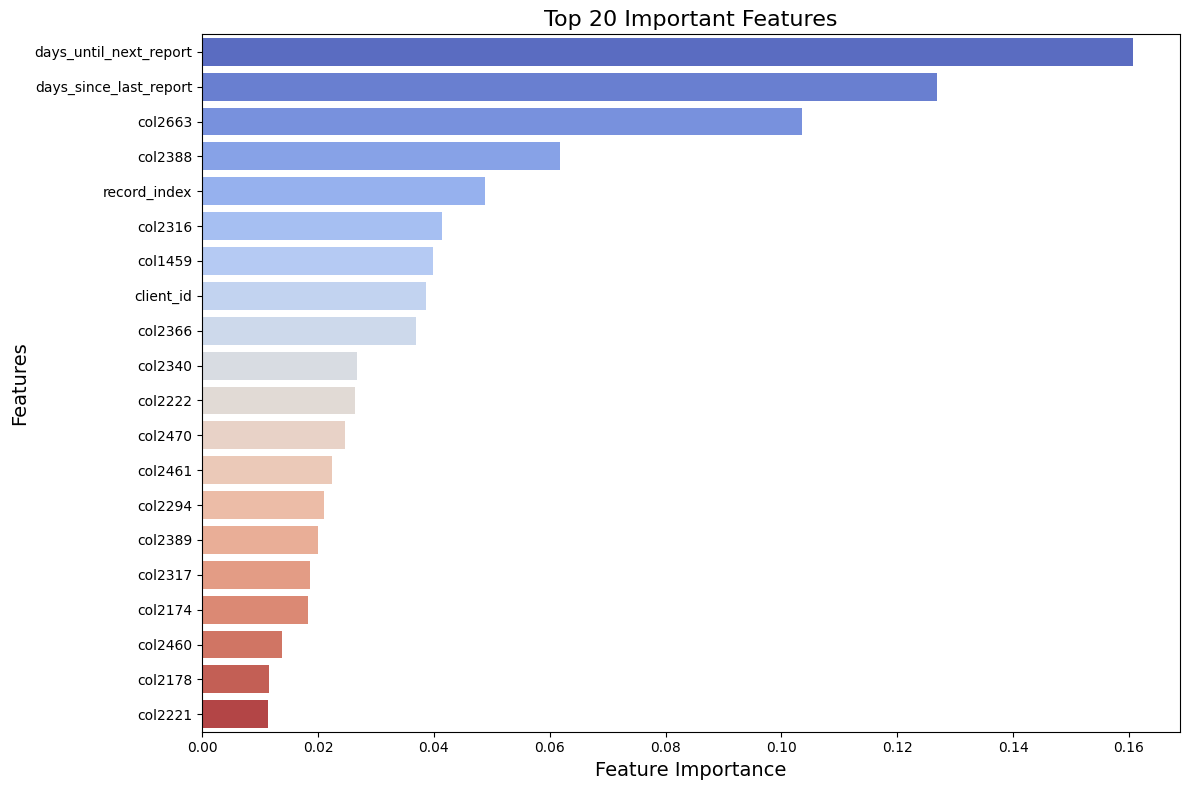

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14456 entries, 0 to 14455
Columns: 2666 entries, report_date to col2663
dtypes: datetime64[ns](1), float64(2316), int64(3), object(346)
memory usage: 294.0+ MB
None

Статистика числовых признаков:
                         report_date     client_id        target      col1  \
count                          14456  14456.000000  14456.000000  3.000000   
mean   2022-06-05 05:06:12.551189760   2853.066270      0.030160  0.333333   
min              2021-02-01 00:00:00      1.000000      0.000000  0.000000   
25%              2022-02-01 00:00:00   1186.000000      0.000000  0.000000   
50%              2022-07-01 00:00:00   2568.000000      0.000000  0.000000   
75%              2022-11-01 00:00:00   4258.250000      0.000000  0.500000   
max              2023-02-01 00:00:00   8302.000000      1.000000  1.000000   
std                              NaN   1957.002315      0.171035  0.577350   

           col2       col3   

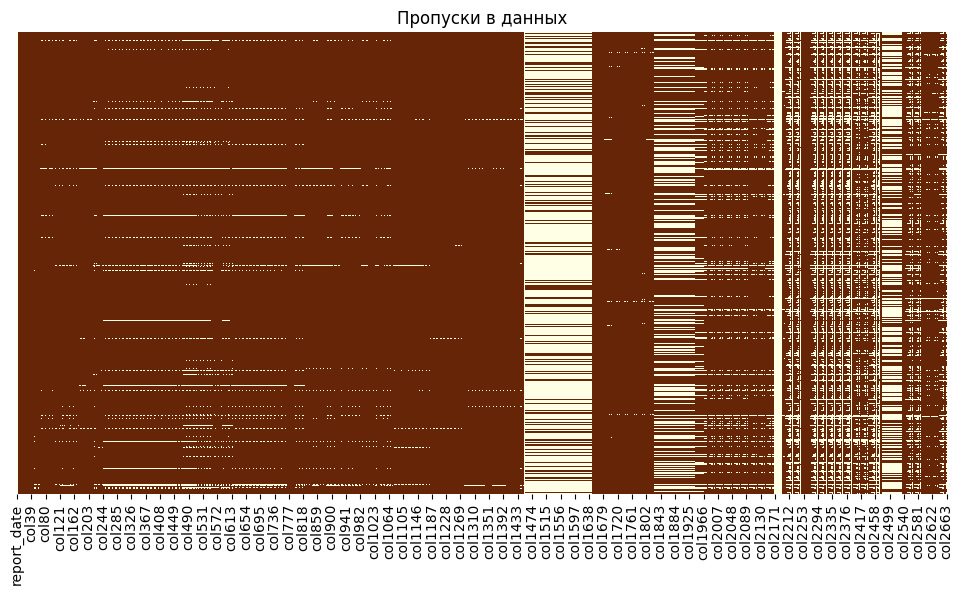

/var/folders/v2/5myb5nld7p3773x7t2160vdc0000gn/T/ipykernel_5302/2772150502.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=data_train, palette='viridis')


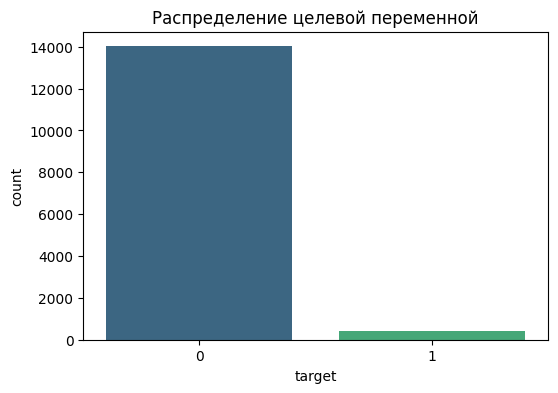

In [10]:
# Загрузка данных
train_data = pd.read_csv('new_train.csv')

# Предобработка данных
def preprocess_data(data):
    X = data.drop(columns=['target', 'report_date', 'col1454'], errors='ignore')
    y = data['target']
    return X, y

X_train, y_train = preprocess_data(train_data)

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Обучение модели Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Получение важности признаков
feature_importance = gb_model.feature_importances_
features = X_train.columns

# Создание DataFrame для важности признаков
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Построение графика важных признаков
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='coolwarm')
plt.title('Top 20 Important Features', fontsize=16)
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.tight_layout()
plt.show()

# Информация о данных
print("Информация о данных:")
print(data_train.info())

# Статистика числовых признаков
print("\nСтатистика числовых признаков:")
print(data_train.describe())

# Пропуски в данных
plt.figure(figsize=(12, 6))
sns.heatmap(data_train.isnull(), cbar=False, cmap='YlOrBr', yticklabels=False)
plt.title("Пропуски в данных")
plt.show()

# Дисбаланс целевой переменной
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=data_train, palette='viridis')
plt.title("Распределение целевой переменной")
plt.show()

<h3>Обучаем модель


Accuracy: 0.9816
F1-score: 0.1928


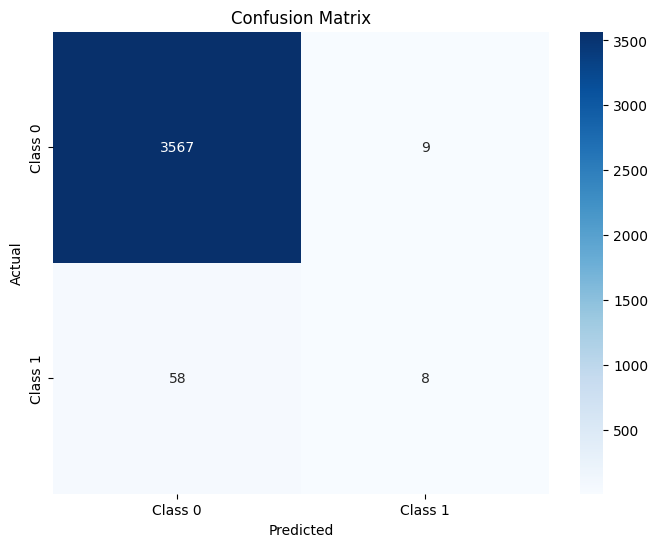

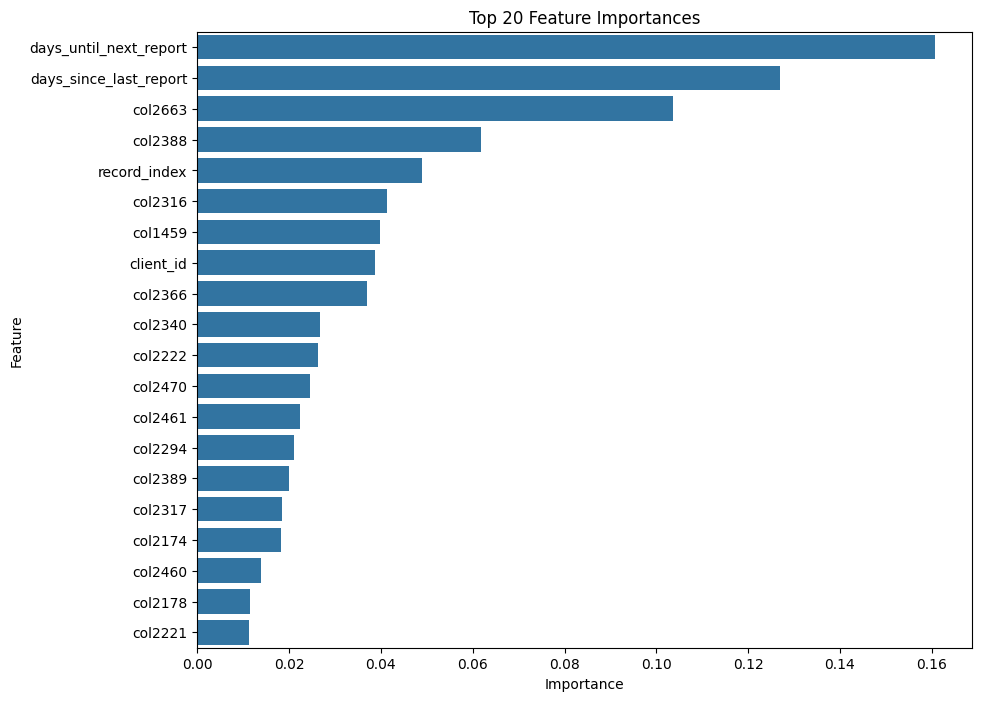

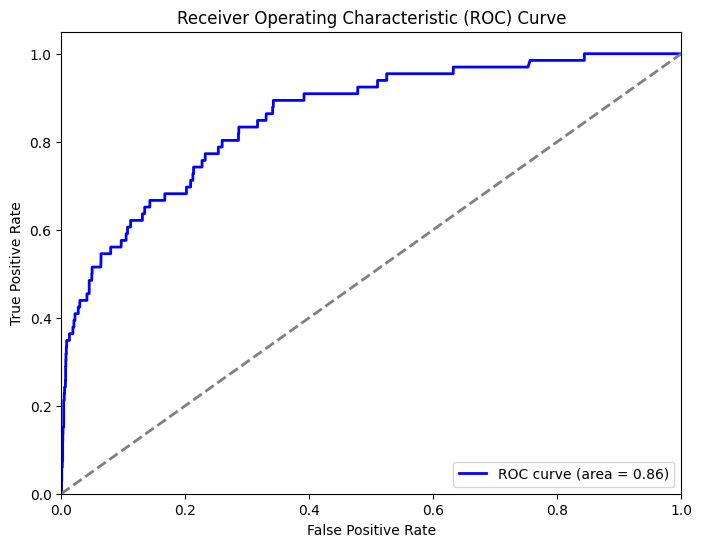

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.98      1.00      0.99      3576
     Class 1       0.47      0.12      0.19        66

    accuracy                           0.98      3642
   macro avg       0.73      0.56      0.59      3642
weighted avg       0.97      0.98      0.98      3642



In [11]:
# Загрузка данных
train_data = pd.read_csv('new_train.csv')
valid_data = pd.read_csv('new_valid.csv')

# Предобработка данных
def preprocess_data(data):
    # Удаляем ненужные колонки
    X = data.drop(columns=['target', 'report_date', 'col1454'], errors='ignore')
    y = data['target']
    return X, y

X_train, y_train = preprocess_data(train_data)
X_valid, y_valid = preprocess_data(valid_data)

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Обучение модели Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Предсказания и оценка модели
y_pred = gb_model.predict(X_valid_scaled)
accuracy = accuracy_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'F1-score: {f1:.4f}')

# Матрица ошибок
cm = confusion_matrix(y_valid, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Важность признаков
feature_importance = gb_model.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importances')
plt.show()

# ROC-кривая
from sklearn.metrics import roc_curve, auc

y_prob = gb_model.predict_proba(X_valid_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_valid, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Отчет о классификации
print('Classification Report:')
print(classification_report(y_valid, y_pred, target_names=['Class 0', 'Class 1']))